# Transfer Learning from PatchCore to MLP
The following document will attempt a solutiont to abstract PatchCore away in order to hide the memory bank.  
By hiding the memory bank, we become able to use HomoMorphic Encryption on the model.

**This document follows these steps:**
1. Train PatchCore on half the dataset **dataset_a** -> result: patchCore model (**ModelA**)
2. Evaluate the resulting model (we care about AUROC)
3. Use **modelA** to add labels (*anomaly scores*)to all patches within the images in **dataset_b** -> **annotated_dataset_b**.
4. Use annotated_dataset_b to train a MLP model **ModelB**
5. With ModelB, estimate patch scores for test data patches.
6. Test the model effictiveness of ModelB.
7. Conclusion on the performance of ModelB

## (1) Training PatchCore

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pytorch_lightning import Trainer, seed_everything

from config import get_configurable_parameters
from data import get_datamodule
from models import get_model
from utils.callbacks import LoadModelCallback, get_callbacks

# config
config = get_configurable_parameters(model_name="patchcore", config_path="config.yaml")
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

# prepare dataomdule
datamodule = get_datamodule(config)

# prepare model
model = get_model(config)
callbacks = get_callbacks(config)

# fit the model
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 24.9 M
3 | image_metrics         | AnomalibMetric

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## (2) Evaluate the resulting model model_a

In [3]:
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9715957045555115
       pixel_AUROC          0.9759382605552673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_AUROC': 0.9759382605552673, 'image_AUROC': 0.9715957045555115}]

## (3) Annotate dataset_b

In [4]:
import json
import torch

from inferencer import TorchInferencer
from data.utils import get_image_filenames, read_image


inferencer = TorchInferencer(
    config=config,
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
    device="auto"
)
model = inferencer.model.model
filenames = get_image_filenames(path="datasets/MVTec_b/grid/")

dataset_b_annotated = {
    "threshold": None,
    "images": []
}
print("Starting to process images...")
for filename in filenames:
    image_arr = read_image(filename)

    metadata = inferencer.metadata
    metadata["image_shape"] = image_arr.shape[:2]
    processed_image = inferencer.pre_process(image_arr)

    # generating embeddings
    with torch.no_grad():
        features = model.feature_extractor(processed_image)
    features = {layer: model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = model.generate_embedding(features)
    batch_size, _, width, height = embedding.shape
    embedding = model.reshape_embedding(embedding)

    # calculating anomaly score / patch
    patch_scores, _ = model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    
    dataset_b_annotated["images"].append({
        "filename": filename.name,
        "embedding": embedding.tolist(),
        "patch_scores": patch_scores.tolist(),
    })
    if len(dataset_b_annotated['images']) % 10 == 0:
        print(f"Finished {len(dataset_b_annotated['images'])} out of {len(filenames)} images")

print(f"inference finished for {len(filenames)} images")

Starting to process images...
Finished 10 out of 131 images
Finished 20 out of 131 images
Finished 30 out of 131 images
Finished 40 out of 131 images
Finished 50 out of 131 images
Finished 60 out of 131 images
Finished 70 out of 131 images
Finished 80 out of 131 images
Finished 90 out of 131 images
Finished 100 out of 131 images
Finished 110 out of 131 images
Finished 120 out of 131 images
Finished 130 out of 131 images
inference finished for 131 images


## (4) Train the MLP model

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# preparing data 
x, y = [], []

for image in dataset_b_annotated['images']:  # flattening data into X, and Y
    x = x + image['embedding']
    y = y + image['patch_scores']


In [89]:
import time

s = time.time()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# training the model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', random_state=42)
mlp.fit(X_train, y_train)

print(f"Took {int((time.time() - s) / 60)} minutes")

Took 16 minutes


## (5) Evaluating the MLP model on input data

In [90]:
# Simple evaluation of the model
import numpy as np
from sklearn.metrics import mean_squared_error

y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
r2_score = mlp.score(X_test, y_test)
print(f"R^2 score: {r2_score:.2f}")

RMSE: 1.134598358953882
R^2 score: 0.89


### Alternative models
I have tested different configuration of the MLP model. Here's a summary of them and their evaluation

| Architecture | Activation | $R^2$ | RMSE  |
|--------------|------------|-------|-------|
| 100x50       |    relu    | 0.89  | 1.134 |
| 500x100x5    |    relu    | 0.90  | 1.053 |
| 500x500      |    relu    | 0.90  | 1.071 |
| 1000x1000    |    relu    | 0.90  | 1.032 |
| 100x50       |  logistic  | 0.82  | 1.426 |
| 100x50       |  identity  | 0.68  | 1.908 |
| 100x100      |    tanh    | 0.74  | 1.697 |


## (6) Testing PatchCore anomaly scoring performance against our new MLP model

### Steps 
1. Prepare the dataset to be used. This is a list of embeddings for all images in the dataset
2. Run PatchCore on the given dataset and store the resulting patch score values in an array
3. Run the same dataset on the MLP model, and store the results
4. Plot both numbers against each other

Question: What exactly should we plot?
We need a good metric to measure the deviation of the MLP results from the patchCore results.

In [9]:
## step1 - prepare the test dataset
import torch

from data.utils import get_image_filenames, read_image
from inferencer import TorchInferencer
from post_processing import Visualizer

filenames = get_image_filenames(path="datasets/MVTec_a/grid/test")

inferencer = TorchInferencer(
    config="config.yaml",
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
)
patchcore_model = inferencer.model.model

metadata = getattr(inferencer, "metadata")

embeddings = []
for filename in filenames:
    image_arr=read_image(filename)
    metadata["image_shape"] = image_arr.shape[:2]

    processed_image = inferencer.pre_process(image_arr)

    with torch.no_grad():
        features = patchcore_model.feature_extractor(processed_image)  # 2nd and 3rd layer
    
    features = {layer: patchcore_model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = patchcore_model.generate_embedding(features)

    batch_size, _, width, height = embedding.shape
    embedding = patchcore_model.reshape_embedding(embedding)
    embeddings.append(embedding)

len(embeddings)

78

In [10]:
## step 2 - patch score results
### patchcore results for the given 78 images flattened
patchcore_results = []
for embedding in embeddings:
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_results += patch_scores_patchcore

In [91]:
## step 3 - MLP results
### MLP model results for the given 78 images
mlp_results = []
for embedding in embeddings:
    patch_scores_mlp_model = mlp.predict(embedding).tolist()
    mlp_results += patch_scores_mlp_model

In [92]:
import matplotlib.pyplot as plt


def draw_two_plots(y1, y2, x_axis="Patch Index", y_axis="Anomaly Score", title="PatchCore vs MLP"):
    fig, ax = plt.subplots()
    
    ax.plot(y1, color='red', label="patchCore")
    ax.plot(y2, color='blue', label="MLP")
    
    # Add labels and title
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_title(title)
    ax.legend()
    plt.show()

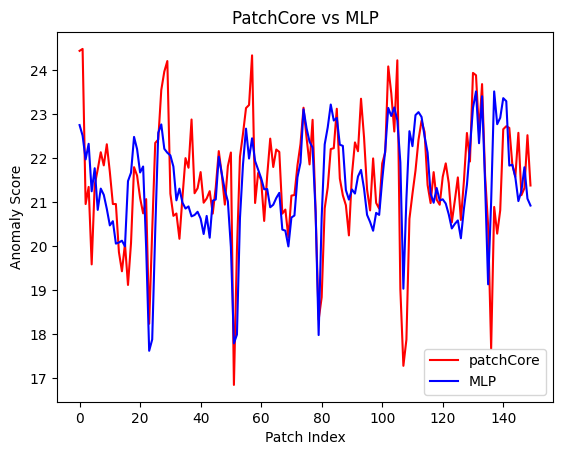

In [93]:
draw_two_plots(patchcore_results[31000:31150], mlp_results[31000:31150])


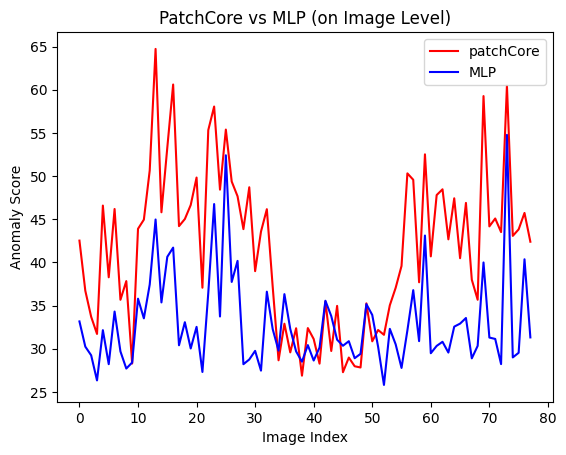

In [94]:
# Measuring the image-level anomaly scores deviation

patchcore_image_results = []
for embedding in embeddings:  # We use the Max function to determine the image patch score
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_image_results.append(max(patch_scores_patchcore))
len(patchcore_image_results)

mlp_image_results = []
for embedding in embeddings:
    patch_scores_mlp_model = mlp.predict(embedding).tolist()
    mlp_image_results.append(max(patch_scores_mlp_model))
len(mlp_image_results)

draw_two_plots(patchcore_image_results, mlp_image_results, x_axis="Image Index", title='PatchCore vs MLP (on Image Level)')

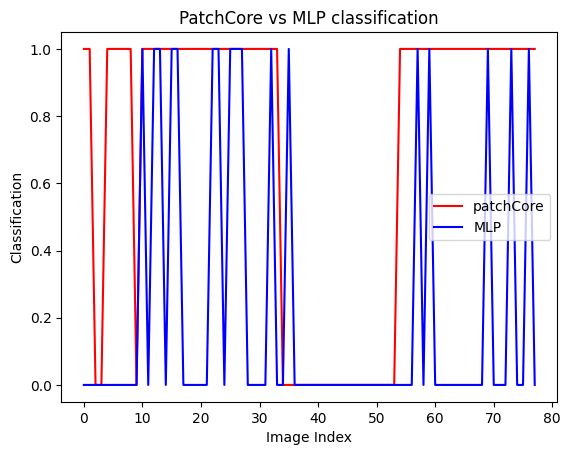

In [95]:
# Measuring the image-level classification deviation
threshold = inferencer.metadata["image_threshold"]

patchcore_image_results_class = [1 if res > threshold else 0 for res in patchcore_image_results]
mlp_image_results_class        = [1 if res > threshold else 0 for res in mlp_image_results]

draw_two_plots(patchcore_image_results_class, mlp_image_results_class, x_axis="Image Index", y_axis="Classification", title='PatchCore vs MLP classification')

In [96]:
sum(patchcore_image_results_class), sum(mlp_image_results_class)

(55, 17)

## Conclusion

The MLP model does a better job than the Linear regression model, but it's still not close enough to the patchCore results.

In a following experiment, we will add the anomalous data to the dataset_b to observe if that improves the model's ability to predict anomalous data.

## Appendix (additional graphs)

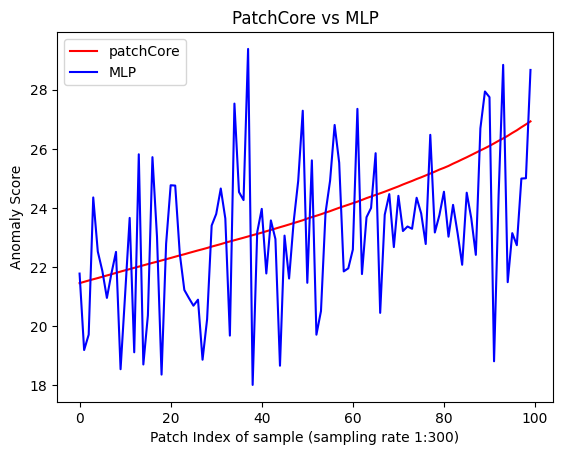

In [97]:
# Clearly show the deviation by ordering the patchCore results by lowest to highest

# this line creates a list of pairs of (patchcore result, MLP result) for each patch
y12 = zip(patchcore_results, mlp_results)

# we sort by patchcore result from lowest to highest - while keeping the second element to the MLP value
y12 = sorted(y12, key=lambda x: x[0])

# we split again patchcore (y1) from MLP (y2) so we can plot them
y1 = [x[0] for x in y12]
y2 = [x[1] for x in y12]
draw_two_plots(y1[20000:50000:300], y2[20000:50000:300], x_axis="Patch Index of sample (sampling rate 1:300)")

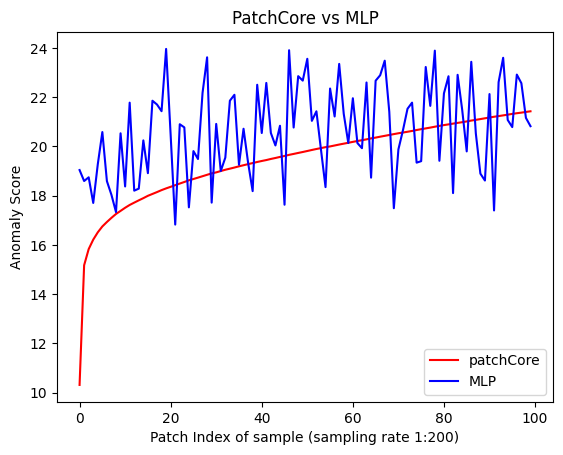

In [98]:
# Drawing 200 patch scores samples at 1/20 (we present 1 then skip 19, for 100 times)
draw_two_plots(y1[0:20000:200], y2[0:20000:200], x_axis="Patch Index of sample (sampling rate 1:200)")

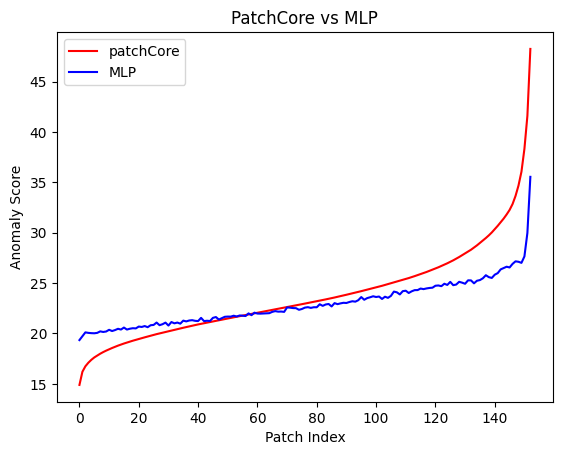

In [99]:
# sampling by taking the mean
import numpy as np

sample_width = 400
y1_sampled, y2_sampled = [], []
for lower_bound in range(1, len(y1), sample_width):
    upper_bound = lower_bound + sample_width
    upper_bound = len(y1) if upper_bound > len(y1) else upper_bound
    y1_sampled.append(np.mean(y1[lower_bound:upper_bound]))
    y2_sampled.append(np.mean(y2[lower_bound:upper_bound]))

draw_two_plots(y1_sampled, y2_sampled)

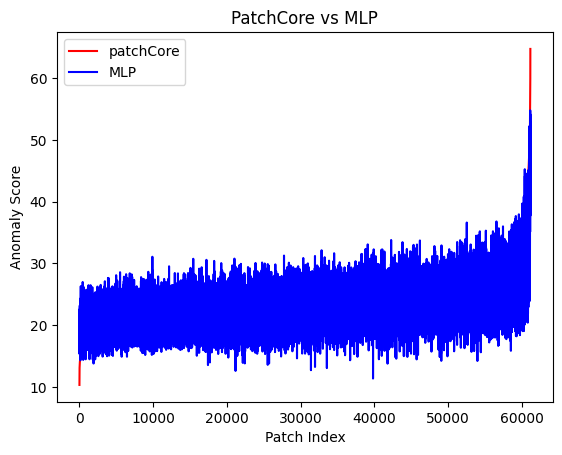

In [100]:
draw_two_plots(y1, y2)

### plotting image comparisons over ordered results

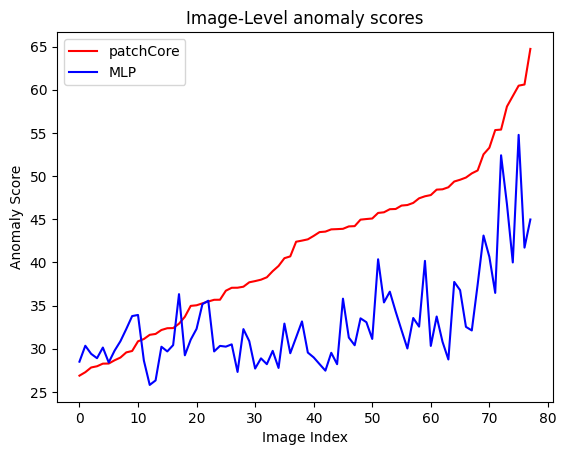

In [101]:
y12_images = zip(patchcore_image_results, mlp_image_results)

# we sort by patchcore result from lowest to highest - while keeping the second element to the MLP value
y12_images = sorted(y12_images, key=lambda x: x[0])

y1_images = [x[0] for x in y12_images]
y2_images = [x[1] for x in y12_images]
draw_two_plots(y1_images, y2_images, x_axis="Image Index", title="Image-Level anomaly scores")

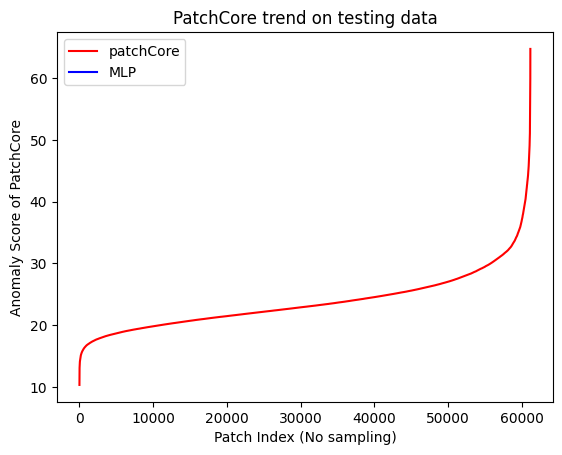

In [102]:
# This last graph should give an insight on the distribution of anomaly scores on the test dataset. 

draw_two_plots(y1, [], x_axis="Patch Index (No sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")

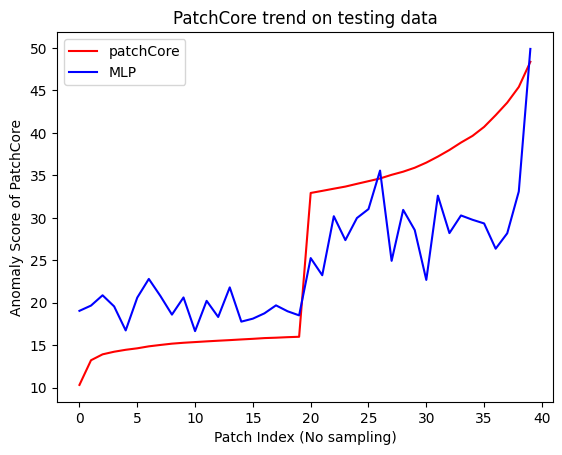

In [103]:
# out of curiousity, let's also see how the MLP model follows PatchCore on the boundaries and the middle sections

y1_boundaries = y1[:500:25] + y1[58652::125]  # 20 samples out of the first 500 points
y2_boundaries = y2[:500:25] + y2[58652::125]  # 20 samples out of the last 2500 points

draw_two_plots(y1_boundaries, y2_boundaries, x_axis="Patch Index (No sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")